In [1]:
import sys
import os
import argparse

import torch
import matplotlib.pyplot as plt

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


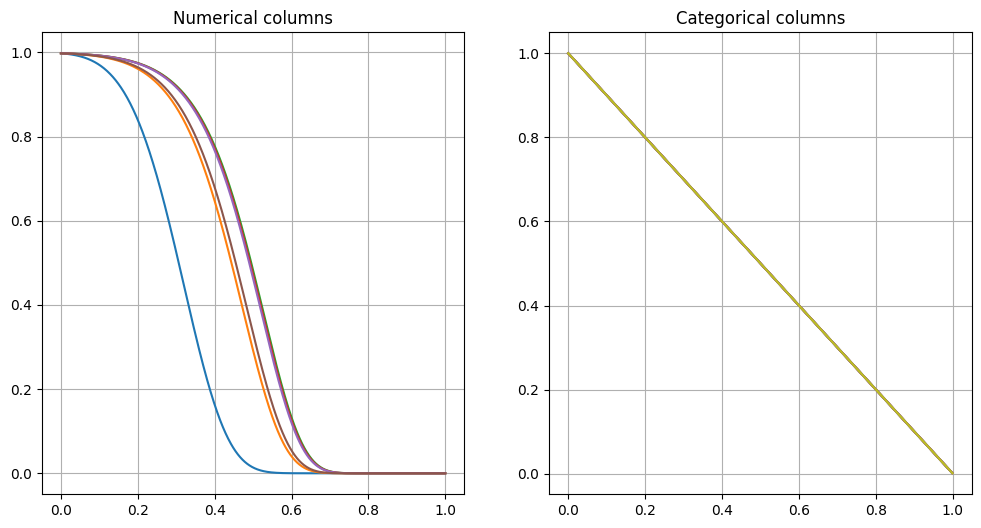

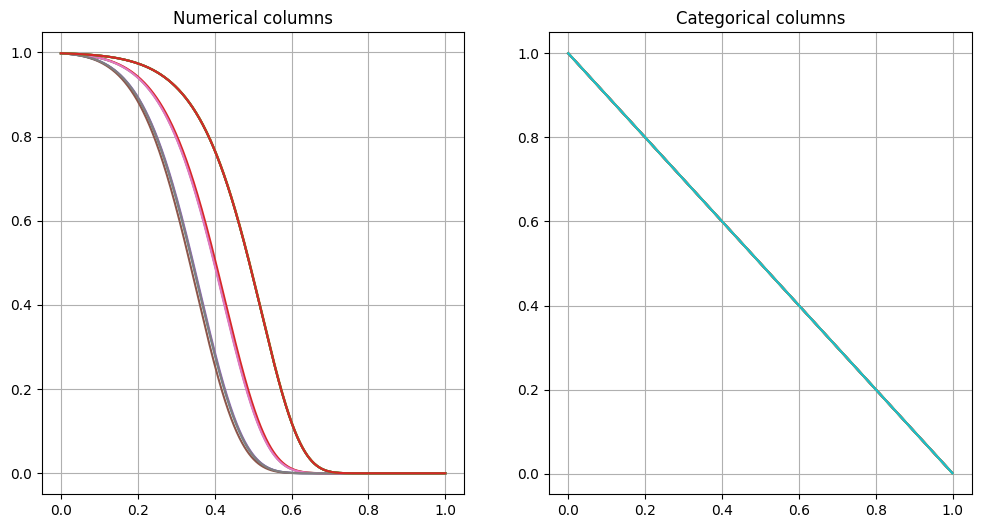

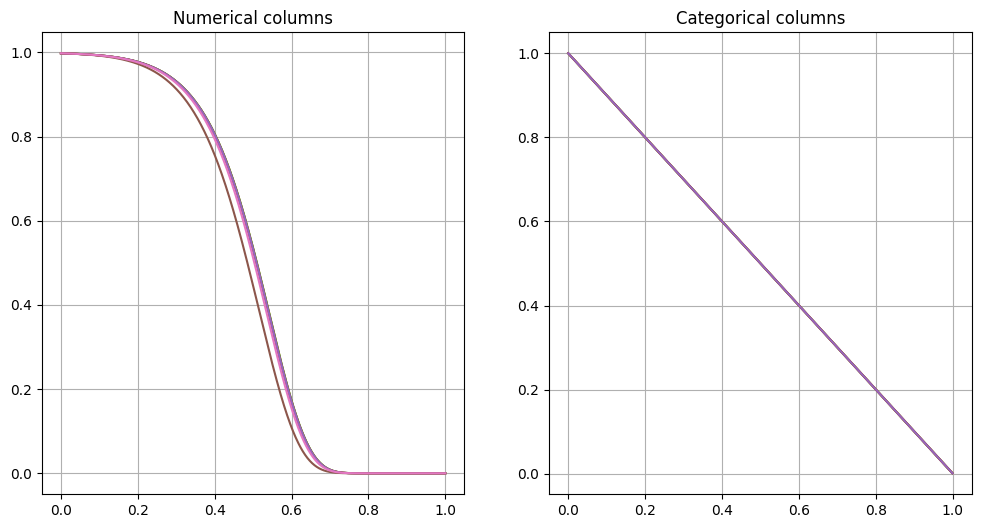

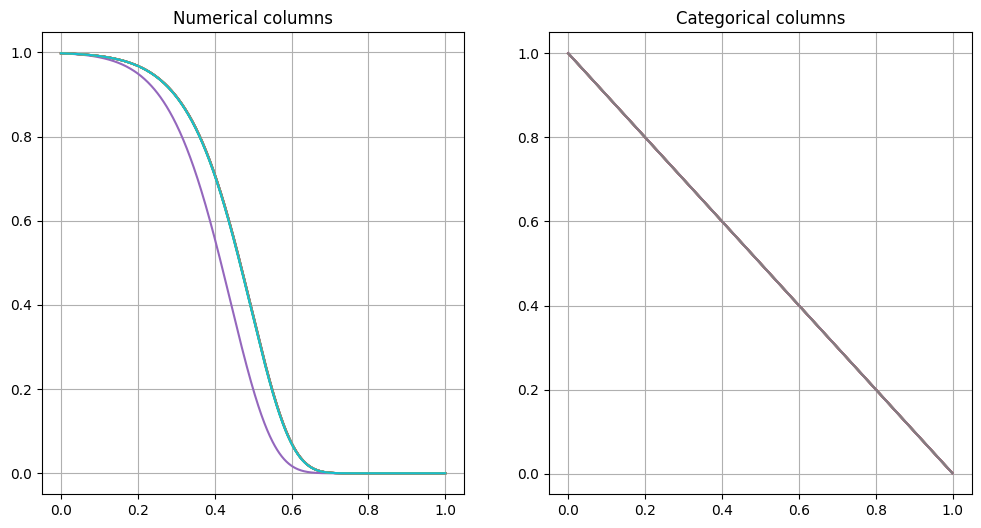

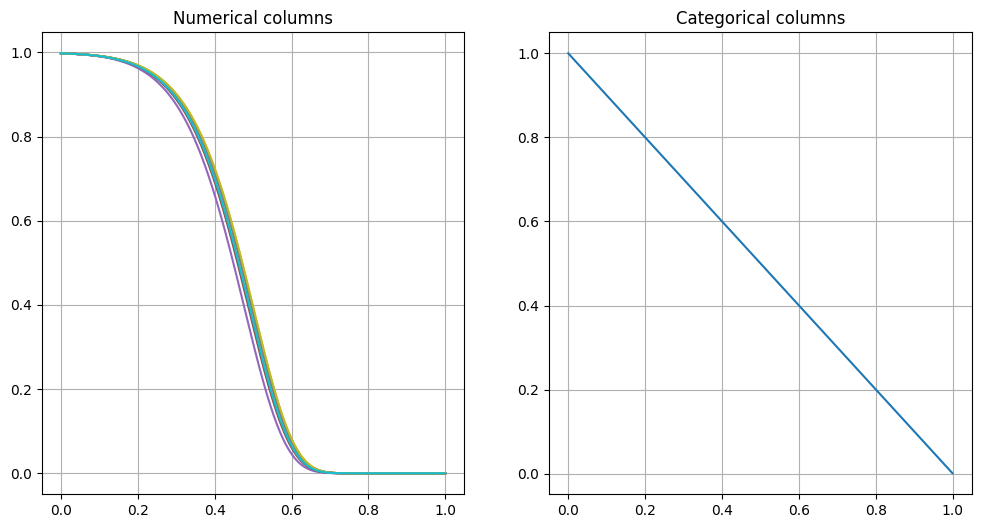

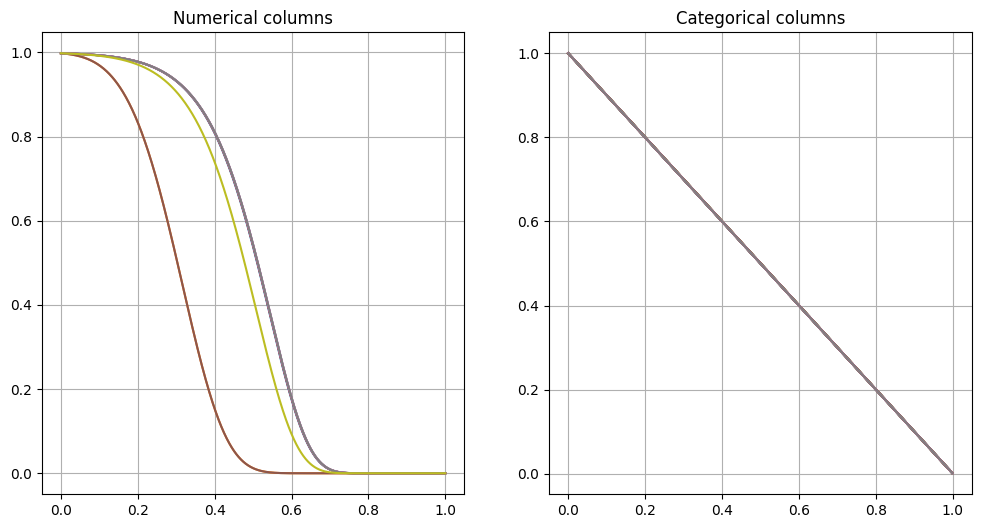

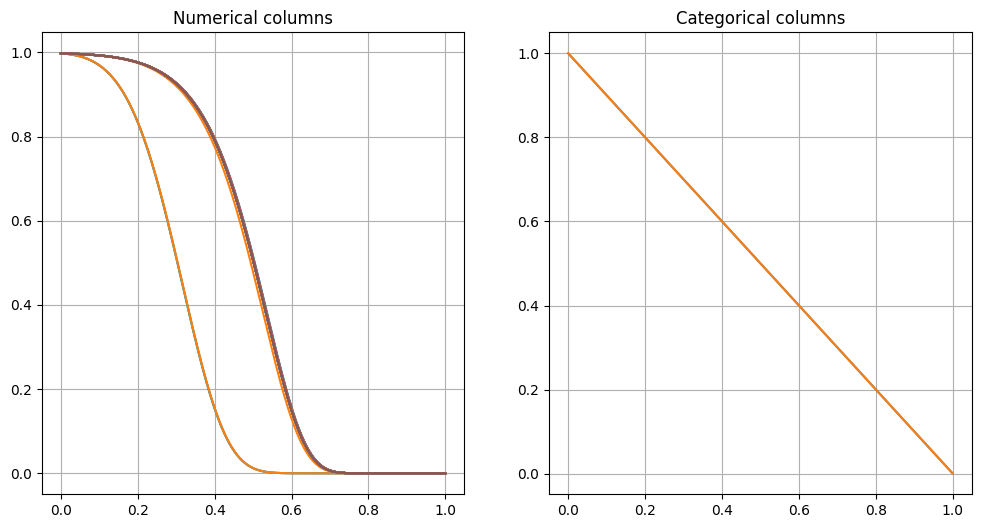

In [2]:
def get_args(dataname='adult', expname=None):
    parser = argparse.ArgumentParser(description='Training of TabDiff')

    # General configs
    parser.add_argument('--dataname', type=str, default='adult', help='Name dataset, one of those in data/ dir')
    parser.add_argument('--mode', type=str, default='train', help='train or test')
    parser.add_argument('--method', type=str, default='tabdiff', help='Currently we only release our model TabDiff. Baselines will be released soon.')
    parser.add_argument('--gpu', type=int, default=0, help='GPU index')
    parser.add_argument('--debug', action='store_true', help='Enable debug mode')
    parser.add_argument('--no_wandb', action='store_true', help='disable wandb')
    parser.add_argument('--exp_name', type=str, default=None, help='Experiment name, used to name log directories and the wandb run name')
    parser.add_argument('--deterministic', action='store_true', help='Whether to make the entire process deterministic, i.e., fix global random seeds')

    # Configs for tabdiff
    parser.add_argument('--y_only', action='store_true', help='Train guidance model that only model the target column')
    parser.add_argument('--non_learnable_schedule', action='store_true', help='disable learnable noise schedule')

    # Configs for testing tabdiff
    parser.add_argument('--num_samples_to_generate', type=int, default=None, help='Number of samples to be generated while testing')
    parser.add_argument('--ckpt_path', type=str, default=None, help='Path to the model checkpoint to be tested')
    parser.add_argument('--report', action='store_true', help="Report testing mode: this mode sequentially runs <num_runs> test runs and report the avg and std")
    parser.add_argument('--num_runs', type=int, default=20, help="Number of runs to be averaged in the report testing mode")

    # Configs for imputation
    parser.add_argument('--impute', action='store_true')
    parser.add_argument('--trial_start', type=int, default=0)
    parser.add_argument('--trial_size', type=int, default=50)
    parser.add_argument('--resample_rounds', type=int, default=1)
    parser.add_argument('--impute_condition', type=str, default="x_t")
    parser.add_argument('--y_only_model_path', type=str, default=None, help="Path to the y_only model checkpoint that will be used as the unconditional guidance model")
    parser.add_argument('--w_num', type=float, default=0.6)
    parser.add_argument('--w_cat', type=float, default=0.6);

    args = parser.parse_args(args=[])
    args.mode = 'test'
    args.device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')
    args.dataname = dataname
    args.exp_name = expname
    args.no_wandb = True
    return args

class DisablePrint:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def load_tabdiff(args):
    import glob
    import json
    import os
    import pickle
    import random

    import numpy as np
    from tabdiff.metrics import TabMetrics
    from tabdiff.modules.main_modules import UniModMLP
    from tabdiff.modules.main_modules import Model
    from tabdiff.models.unified_ctime_diffusion import UnifiedCtimeDiffusion
    from tabdiff.trainer import Trainer
    import src
    import torch

    from torch.utils.data import DataLoader
    import argparse
    import warnings

    import wandb

    from copy import deepcopy

    from utils_train import TabDiffDataset

    # warnings.filterwarnings('ignore')

    device = args.device

    ## Disable scientific numerical format
    np.set_printoptions(suppress=True)
    torch.set_printoptions(sci_mode=False)

    ## Get data info
    dataname = args.dataname
    data_dir = f'data/{dataname}'
    info_path = f'data/{dataname}/info.json'
    with open(info_path, 'r') as f:
        info = json.load(f)
    
    ## Set up flags
    is_dcr = 'dcr' in dataname

    ## Set experiment name
    exp_name = args.exp_name
    if args.exp_name is None:
        exp_name = 'non_learnable_schedule' if args.non_learnable_schedule else 'learnable_schedule'
    exp_name += '_y_only' if args.y_only else ''
    
    ## Load configs
    curr_dir = 'tabdiff' #os.path.dirname(os.path.abspath(__file__))
    config_path = f'{curr_dir}/configs/tabdiff_configs.toml'
    raw_config = src.load_config(config_path)
    
    print(f"{args.mode.capitalize()} Mode is Enabled")
    num_samples_to_generate = None
    ckpt_path = None
    if args.mode == 'train':
        print("NEW training is started")
    elif args.mode == 'test':
        num_samples_to_generate = args.num_samples_to_generate
        ckpt_path = args.ckpt_path
        if ckpt_path is None:
            ckpt_parent_path = f"{curr_dir}/ckpt/{dataname}/{exp_name}"
            ckpt_path_arr = glob.glob(f"{ckpt_parent_path}/best_ema_model*")
            assert ckpt_path_arr, f"Cannot not infer ckpt_path from {ckpt_parent_path}, please make sure that you first train a model before testing!"
            ckpt_path = ckpt_path_arr[0]
            # ckpt_path = f"{ckpt_parent_path}/model_2000.pt"
        config_path = os.path.join(os.path.dirname(ckpt_path), 'config.pkl')
        if os.path.exists(config_path):
            with open(config_path, 'rb') as f:
                cached_raw_config = pickle.load(f)
                print(f"Found cached config at {config_path}")
        raw_config = cached_raw_config
    
    
    ## Creat model_save and result paths
    model_save_path, result_save_path = None, None
    if args.mode == 'train':
        model_save_path = 'debug/ckpt' if args.debug else f'{curr_dir}/ckpt/{dataname}/{exp_name}'
        result_save_path = model_save_path.replace('ckpt', 'result')  #i.e., f'{curr_dir}/results/{dataname}/{exp_name}'
    elif args.mode == 'test':
        if args.report:
            result_save_path = f"eval/report_runs/{exp_name}/{dataname}"
        else:
            result_save_path = os.path.dirname(ckpt_path).replace('ckpt', 'result')    # infer the exp_name from the ckpt_name
    raw_config['model_save_path'] = model_save_path
    raw_config['result_save_path'] = result_save_path
    if model_save_path is not None:
        if not os.path.exists(model_save_path):
            os.makedirs(model_save_path)
    if result_save_path is not None:
        if not os.path.exists(result_save_path):
            os.makedirs(result_save_path)
    
    ## Make everything determinstic if needed
    raw_config['deterministic'] = args.deterministic
    if args.deterministic:
        print("DETERMINISTIC MODE is enabled!!!")
        ## Set global random seeds
        torch.manual_seed(0)
        random.seed(0)
        np.random.seed(0)

        ## Ensure deterministic CUDA operations
        os.environ['PYTHONHASHSEED'] = '0'
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # or ':16:8'
        torch.use_deterministic_algorithms(True)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(0)
            torch.cuda.manual_seed_all(0)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
    
    ## Set debug mode parameters
    if args.debug:  # fast eval for DEBUG mode
        raw_config['train']['main']['check_val_every'] = 2
        raw_config['diffusion_params']['num_timesteps'] = 4
        raw_config['train']['main']['batch_size'] = 4096
        raw_config['sample']['batch_size'] = 10000

    ## Load training data
    batch_size = raw_config['train']['main']['batch_size']

    train_data = TabDiffDataset(dataname, data_dir, info, y_only=args.y_only, isTrain=True, dequant_dist=raw_config['data']['dequant_dist'], int_dequant_factor=raw_config['data']['int_dequant_factor'])
    train_loader = DataLoader(
        train_data,
        batch_size = batch_size,
        shuffle = True,
        num_workers = 4,
    )
    d_numerical, categories = train_data.d_numerical, train_data.categories
    
    val_data = TabDiffDataset(dataname, data_dir, info, y_only=args.y_only, isTrain=False, dequant_dist=raw_config['data']['dequant_dist'], int_dequant_factor=raw_config['data']['int_dequant_factor'])

    ## Load Metrics
    real_data_path = f'synthetic/{dataname}/real.csv'
    test_data_path = f'synthetic/{dataname}/test.csv'
    val_data_path = f'synthetic/{dataname}/val.csv'
    if not os.path.exists(val_data_path):
        print(f"{args.dataname} does not have its validation set. During MLE evaluation, a validation set will be splitted from the training set!")
        val_data_path = None
    if args.mode == 'train':
        metric_list = ["density"]
    else:
        if is_dcr:
            metric_list = ["dcr"]
        else:
            metric_list = [
                "density", 
                "mle", 
                "c2st",
            ]
    metrics = TabMetrics(real_data_path, test_data_path, val_data_path, info, device, metric_list=metric_list)
    
    ## Load the module and models
    raw_config['unimodmlp_params']['d_numerical'] = d_numerical
    raw_config['unimodmlp_params']['categories'] = (categories+1).tolist()  # add one for the mask category
    if args.y_only:
        raw_config['unimodmlp_params']['use_mlp'] = False     # drop the mlp when training the unconditional model
        raw_config['unimodmlp_params']['dim_t'] = 128   #reduce the size of the mlp
        main_model_path = args.ckpt_path
        if main_model_path is None:
            main_model_parent_path = f"{curr_dir}/ckpt/{dataname}/{exp_name.replace('_y_only', '')}"
            main_model_path_arr = glob.glob(f"{main_model_parent_path}/best_ema_model*")
            assert main_model_path_arr, f"Cannot not infer the main model's ckpt_path from {main_model_parent_path}, please make sure that you first train a main model before training the y_only model!"
            main_model_path = main_model_path_arr[0]
        main_model_configs = pickle.load(open(os.path.join(os.path.dirname(main_model_path), 'config.pkl'), 'rb'))
        if main_model_configs['diffusion_params']['scheduler'] == "power_mean_per_column": # if learnable schedule is enabled in the main model, we need to infer noise params of the target column from the main model ckpt and train the y_only model with those params
            from tabdiff.models.noise_schedule import PowerMeanNoise_PerColumn, LogLinearNoise_PerColumn
            if info['task_type'] == 'regression':
                noise_schedule = PowerMeanNoise_PerColumn(
                    num_numerical=main_model_configs['unimodmlp_params']['d_numerical'], 
                    **main_model_configs['diffusion_params']['noise_schedule_params']
                )
                raw_config['diffusion_params']['noise_schedule_params']['rho'] = noise_schedule.rho()[0].item()    # the target col is placed at the first position
            else:
                noise_schedule = LogLinearNoise_PerColumn(
                    num_categories=len(main_model_configs['unimodmlp_params']['categories']), 
                    **main_model_configs['diffusion_params']['noise_schedule_params']
                )
                raw_config['diffusion_params']['noise_schedule_params']['k'] = noise_schedule.k()[0].item()    # the target col is placed at the first position
            
    backbone = UniModMLP(
        **raw_config['unimodmlp_params']
    )
    model = Model(backbone, **raw_config['diffusion_params']['edm_params'])
    model.to(device)
    ## Create and load y_only_model for imputation
    y_only_model = None
    if args.impute:
        y_only_model_path = args.y_only_model_path
        if y_only_model_path is None:
            y_only_model_parent_path = f"{curr_dir}/ckpt/{dataname}/{exp_name}_y_only"
            y_only_model_path_arr = glob.glob(f"{y_only_model_parent_path}/best_ema_model*")
            assert y_only_model_path_arr, f"Cannot not infer y_only model's ckpt_path from {y_only_model_parent_path}, please make sure that you first train a y_only model before testing imputation!"
            y_only_model_path = y_only_model_path_arr[0]
        y_only_model_config_path = os.path.join(os.path.dirname(y_only_model_path), 'config.pkl')
        with open(y_only_model_config_path, 'rb') as f:
                y_only_model_config = pickle.load(f)
        y_only_model = UniModMLP(
            **y_only_model_config['unimodmlp_params']
        )
        y_only_model = Model(y_only_model, **y_only_model_config['diffusion_params']['edm_params'])
        y_only_model.to(device)
        # load weights
        state_dicts = torch.load(y_only_model_path, map_location=device)
        y_only_model.load_state_dict(state_dicts['denoise_fn'])

    if not args.y_only and not args.non_learnable_schedule:
        raw_config['diffusion_params']['scheduler'] = 'power_mean_per_column'
        raw_config['diffusion_params']['cat_scheduler'] = 'log_linear_per_column'
    diffusion = UnifiedCtimeDiffusion(
        num_classes=categories,
        num_numerical_features=d_numerical,
        denoise_fn=model,
        y_only_model=y_only_model,
        **raw_config['diffusion_params'],
        device=device,
    )
    num_params = sum(p.numel() for p in diffusion.parameters())
    print("The number of parameters = ", num_params)
    diffusion.to(device)
    diffusion.train()

    ## Print the configs
    printed_configs = json.dumps(raw_config, default=lambda x: int(x) if isinstance(x, np.int64) else x, indent=4)
    print(f"The config of the current run is : \n {printed_configs}")
    
    ## Enable Wandb
    project_name = f"tabdiff_{dataname}"
    raw_config['project_name'] = project_name
    logger = wandb.init(
        project=raw_config['project_name'], 
        name=exp_name,
        config=raw_config,
        mode='disabled' if args.debug or args.no_wandb else 'online',
    )

    ## Load Trainer
    sample_batch_size = raw_config['sample']['batch_size']
    trainer = Trainer(
        diffusion,
        train_loader,
        train_data,
        val_data,
        metrics,
        logger,
        **raw_config['train']['main'],
        sample_batch_size=sample_batch_size,
        num_samples_to_generate=num_samples_to_generate,
        model_save_path=raw_config['model_save_path'],
        result_save_path=raw_config['result_save_path'],
        device=device,
        ckpt_path=ckpt_path,
        y_only=args.y_only
    )
    return trainer.diffusion


for dataname in ['adult', 'default', 'beijing', 'shoppers', 'magic', 'diabetes', 'news']:
    args = get_args(dataname,'tabdiffbench')
    with DisablePrint():
        model = load_tabdiff(args)

    t = torch.linspace(0, 1, 1000, device=args.device).reshape(-1, 1)
    with torch.no_grad():
        num_response = torch.exp(-model.num_schedule.total_noise(t))
        cat_response = torch.exp(-model.cat_schedule.total_noise(t))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(t, num_response)
    plt.title('Numerical columns')
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(t, cat_response)
    plt.title('Categorical columns')
    plt.grid()

In [5]:
model.cat_schedule

LogLinearNoise_PerColumn()